# Regression model intro
## Standard imports

First, setup some standard modules and matplotlib.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

Load the main `sciapy` module and its wrappers for easy access to the used proxy timeseries.

In [2]:
import regressproxy
import sciapy
from sciapy.regress.load_data import load_dailymeanAE, load_dailymeanLya

In [3]:
plt.rcParams["figure.dpi"] = 120

## Model interface

The model is set up part by part, beginning with the more involved proxy models.

### Lyman-$\alpha$ proxy

We start with the Lyman-$\alpha$ proxy, it is not centered (mean-subtracted) and we set the rest of the parameters except `ltscan` to zero.

In [4]:
# load proxy data
plat, plap = load_dailymeanLya()
# setup the model
lya_model = regressproxy.ProxyModel(plat,
                                    plap["Lya"],
                                    center=False,
                                    amp=0,
                                    lag=0,
                                    tau0=0,
                                    taucos1=0, tausin1=0,
                                    taucos2=0, tausin2=0,
                                    ltscan=60)

### AE proxy with lifetime

The AE proxy is also not centered and we start with the same parameters as above.

In [5]:
# load proxy data
paet, paep = load_dailymeanAE()
# setup the model
ae_model = regressproxy.ProxyModel(paet,
                                   paep["AE"],
                                   center=False,
                                   amp=0,
                                   lag=0,
                                   tau0=0,
                                   taucos1=0, tausin1=0,
                                   taucos2=0, tausin2=0,
                                   ltscan=60)

### Offset

We use the `ConstantModel` (inherited from `celerite`) for the constant offset.

In [6]:
offset_model = regressproxy.ConstantModel(value=0.)

### Optional harmonic terms

The harmonic terms are not used here but we include them to show how to set them up.

In [7]:
harm1 = regressproxy.HarmonicModelCosineSine(freq=1, cos=0, sin=0)
harm2 = regressproxy.HarmonicModelCosineSine(freq=2, cos=0, sin=0)

# frequencies should not be fitted
harm1.freeze_parameter("freq")
harm2.freeze_parameter("freq")

### Combined model

We then combine the separate models into a `ModelSet`.

In [8]:
model = regressproxy.ProxyModelSet([("offset", offset_model),
                                    ("Lya", lya_model), ("GM", ae_model),
                                    ("f1", harm1), ("f2", harm2)])

The full model has the following parameters:

In [9]:
model.get_parameter_dict()

OrderedDict([('offset:value', 0.0),
             ('Lya:amp', 0.0),
             ('Lya:lag', 0.0),
             ('Lya:tau0', 0.0),
             ('Lya:taucos1', 0.0),
             ('Lya:tausin1', 0.0),
             ('Lya:taucos2', 0.0),
             ('Lya:tausin2', 0.0),
             ('Lya:ltscan', 60.0),
             ('GM:amp', 0.0),
             ('GM:lag', 0.0),
             ('GM:tau0', 0.0),
             ('GM:taucos1', 0.0),
             ('GM:tausin1', 0.0),
             ('GM:taucos2', 0.0),
             ('GM:tausin2', 0.0),
             ('GM:ltscan', 60.0),
             ('f1:cos', 0.0),
             ('f1:sin', 0.0),
             ('f2:cos', 0.0),
             ('f2:sin', 0.0)])

But we don't need all of them, so we freeze all parameters and thaw the ones we need.
This is easier than the other way around (freezing all unused parameters).

In [10]:
model.freeze_all_parameters()
model.thaw_parameter("offset:value")
model.thaw_parameter("Lya:amp")
model.thaw_parameter("GM:amp")
model.thaw_parameter("GM:tau0")
model.thaw_parameter("GM:taucos1")
model.thaw_parameter("GM:tausin1")

Cross check that only the used parameters are really active:

In [11]:
model.get_parameter_dict()

OrderedDict([('offset:value', 0.0),
             ('Lya:amp', 0.0),
             ('GM:amp', 0.0),
             ('GM:tau0', 0.0),
             ('GM:taucos1', 0.0),
             ('GM:tausin1', 0.0)])

## Model parameters

### Manually setting the parameters

Now we set the model parameters to something non-trivial, with the same order as listed above:

In [12]:
model.set_parameter_vector([-25.6, 6.26, 0.0874, 1.54, 10.52, -0.714])

In [13]:
model.get_parameter_dict()

OrderedDict([('offset:value', -25.6),
             ('Lya:amp', 6.26),
             ('GM:amp', 0.0874),
             ('GM:tau0', 1.54),
             ('GM:taucos1', 10.52),
             ('GM:tausin1', -0.714)])

With the parameters properly set, we can now "predict" the density for any time we wish.
Here we take 25 years half-daily:

In [14]:
times = np.arange(1992, 2017.01, 0.5 / 365.25)
pred = model.get_value(times)

and then plot the result:

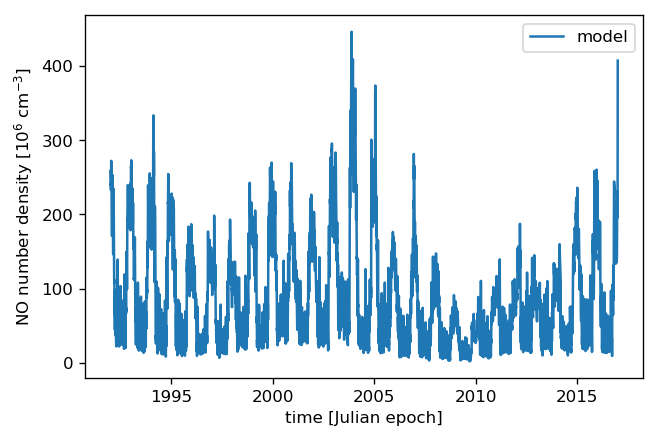

In [15]:
plt.plot(times, pred, label="model")
plt.xlabel("time [Julian epoch]")
# The data were scaled by 10^-6 before fitting
plt.ylabel("NO number density [10$^6$ cm$^{{-3}}$]")
plt.legend();

### Setting the parameters from file

Instead of making up some numbers for the parameters, we can take "real" ones.
We use the ones determined by fitting the model to actual data,
in this case SCIAMACHY nitric oxide daily zonal mean data.

We connect to zenodo and load the contents into memory.
It's a rather small file so that should be no problem, but we need the requests and netCDF4 modules for that.
The alternative would be to download a copy into the same folder as this notebook.

In [16]:
import requests
import netCDF4

def load_data_store(store, variables=None):
    with xr.open_dataset(store, chunks={"lat": 9, "alt": 8}) as data_ds:
        if variables is not None:
            data_ds = data_ds[variables]
        data_ds.load()
        return data_ds

def load_data_url(url, variables=None):
    with requests.get(url, stream=True) as response:
        nc4_ds = netCDF4.Dataset("data", memory=response.content)
        store = xr.backends.NetCDF4DataStore(nc4_ds)
        return load_data_store(store, variables)

In [17]:
zenodo_url = "https://zenodo.org/record/1342701/files/NO_regress_quantiles_pGM_Lya_ltcs_exp1dscan60d_km32.nc"

# If you downloaded a copy, use load_data_store()
# and replace the url by "/path/to/<filename.nc>"
quants = load_data_url(zenodo_url)

The data file contains the median together with the (0.16, 0.84), (0.025, 0.975),
and (0.001, 0.999) quantiles corresponding to the 1$\sigma$, 2$\sigma$, and 3$\sigma$ confidence regions.
In particular, the contents of the quantiles dataset are:

In [18]:
quants

<xarray.Dataset>
Dimensions:            (alt: 16, lat: 18, quantile: 7)
Coordinates:
  * alt                (alt) float64 60.0 62.0 64.0 66.0 ... 84.0 86.0 88.0 90.0
  * lat                (lat) float64 -85.0 -75.0 -65.0 -55.0 ... 65.0 75.0 85.0
  * quantile           (quantile) float64 0.001 0.025 0.16 0.5 0.84 0.975 0.999
Data variables:
    kernel:log_rho     (lat, alt, quantile) float64 -5.52 -5.484 ... -5.161
    kernel:log_sigma   (lat, alt, quantile) float64 2.889 2.915 ... 2.757 2.79
    mean:GM:amp        (lat, alt, quantile) float64 1.3e-06 ... 0.01928
    mean:GM:tau0       (lat, alt, quantile) float64 0.0007629 0.01872 ... 3.671
    mean:GM:taucos1    (lat, alt, quantile) float64 -24.84 -15.97 ... 39.56
    mean:GM:tausin1    (lat, alt, quantile) float64 -7.186 -4.072 ... -1.669
    mean:Lya:amp       (lat, alt, quantile) float64 -19.22 -17.11 ... -3.432
    mean:offset:value  (lat, alt, quantile) float64 5.568 13.26 ... 55.0 62.05

The dimensions of the available parameters are:

In [19]:
quants.lat, quants.alt

(<xarray.DataArray 'lat' (lat: 18)>
 array([-85., -75., -65., -55., -45., -35., -25., -15.,  -5.,   5.,  15.,  25.,
         35.,  45.,  55.,  65.,  75.,  85.])
 Coordinates:
   * lat      (lat) float64 -85.0 -75.0 -65.0 -55.0 -45.0 ... 55.0 65.0 75.0 85.0
 Attributes:
     long_name:  latitude
     units:      degrees_north, <xarray.DataArray 'alt' (alt: 16)>
 array([60., 62., 64., 66., 68., 70., 72., 74., 76., 78., 80., 82., 84., 86.,
        88., 90.])
 Coordinates:
   * alt      (alt) float64 60.0 62.0 64.0 66.0 68.0 ... 82.0 84.0 86.0 88.0 90.0
 Attributes:
     long_name:  altitude
     units:      km)

We loop over the parameter names and set the parameters to the median values (`quantile=0.5`)
for the selected altitude and latitude bin.
The variables in the quantiles file were created using [celerite](https://github.com/dfm/celerite)
which prepends "mean:" to the variables from the mean model.

In [20]:
# select latitude and altitude first
latitude = 65
altitude = 70

for v in model.get_parameter_names():
    model.set_parameter(v, quants["mean:{0}".format(v)].sel(alt=altitude, lat=latitude, quantile=0.5))

The parameters from the file are (actually pretty close to the ones above):

In [21]:
model.get_parameter_dict()

OrderedDict([('offset:value', -25.577781189820513),
             ('Lya:amp', 6.259250259251973),
             ('GM:amp', 0.08741185118056463),
             ('GM:tau0', 1.5387433096984084),
             ('GM:taucos1', 10.520064600296648),
             ('GM:tausin1', -0.7141699243523804)])

We take the same times as above (25 years half-daily) to predict the model values:

In [22]:
pred = model.get_value(times)

and then plot the result again:

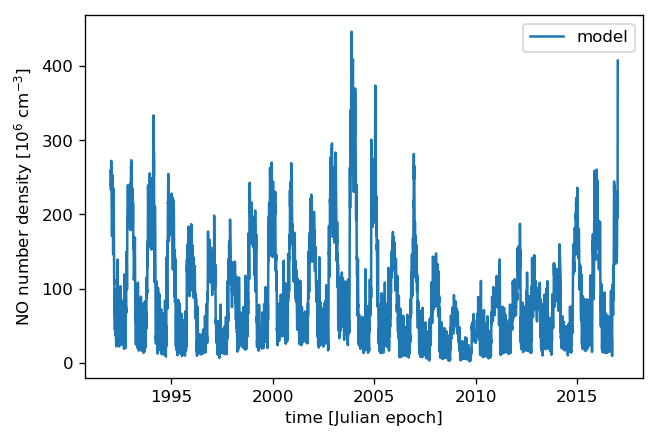

In [23]:
plt.plot(times, pred, label="model")
plt.xlabel("time [Julian epoch]")
# Again, the data were scaled by 10^-6 before fitting, so adjust the X-Axis label
plt.ylabel("NO number density [10$^6$ cm$^{{-3}}$]")
plt.legend();